# Text Analysis 101

In this notebook, we will learn some of the basics of text analysis.  We will be using an example dataset of text-based information from:

* Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

You can find the original data [here](https://ai.stanford.edu/~amaas/data/sentiment/), and a more easily accessible version [on Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?select=IMDB+Dataset.csv) (which is less detailed).  

* To replicate this example, I've trimmed it down to only the first 3499 paired examples, just for practical purposes.  You can do the same, and rename it `IMDB Dataset.csv` for the same results.

In this notebook, we will be using R to do the text analysis, and the `quanteda` package, but there are many other good options - in particular, using Python.  This package has the advantage of being very easy to use, and has an [outstanding collection of tutorials](https://tutorials.quanteda.io/) which cover all of the basic elements of text analysis using this package.  You will likely need to install this package in order to get started:

In [1]:
# you only have to run this the first time
#install.packages('quanteda')  #main package
#install.packages('quanteda.textstats')  #add-on package for text statistics
#install.packages('quanteda.textplots') #add-on package for graphics 

In [2]:
library(quanteda)
library(quanteda.textstats)
library(quanteda.textplots)
library(tidyverse)
library(haven)

Package version: 3.2.1
Unicode version: 13.0
ICU version: 69.1

Parallel computing: 56 of 56 threads used.

See https://quanteda.io for tutorials and examples.

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Terminology

Some quick overview of the way we describe text data.

* The basic element is called a **document** or **texts**, and consists of a bunch of text (no doubt!) and potentially some other identifying information described as **variables** or **features** (e.g. author, date, method of collection, gender).  These can generally be used later in an analysis, but are distinct from the text.
* Within a document, the text is broken down into a set of **tokens** which are roughly like words - but more correctly describe distinct units or objects of text.  
  * For example, "horse" is a token that consists of a single word, whereas "George Washington" is a token that consists of two words.
  * Similarly, "good" is a token that consists of a single word, whereas "not good" is also a token that consists of two words
  * This tokenization process can be highly contextual and depends on the language and the setting of the word (be careful!)
* Documents may also be broken down into **sentences** which are discrete units of the text, and are composed of token.  Note that they may not be "sentences" as we understand that term in English, nor may this even be a meaningful.
* A collection of documents is referred to as a **corpus** (or "body") and is the equivalent of a dataset for text analysis.

## Quick R Intro

If you're not familiar with R, that's OK - it's a pretty simple language.

* `<-` is the **assignment** operator; it creates new variables
  * e.g. `x <- 1` creates a variable named `x` with value 1
  * Inside a function `=` is the same operator
* Functions are `function_name(inputs)` and are stored in packages.
* %>% is the **pipe** operator; it puts whatever is ahead of it as the first input to the function behind it.  
  * You should read it as the conjunction "and then do"
* **Comments** are preceded by `#` sign and aren't run

I'll explain the rest as we go.

# Data Loading

We will get started by (a) loading in our `.csv` of movie reviews and (b) doing some basic clean-up.

In [3]:
reviews <- read_csv("IMDB Dataset.csv")

#recode the sentiment (1 = positive, 0 = negative)
reviews <- reviews %>%
        mutate(sentiment_code = case_when(
            sentiment == "positive" ~ 1,
            sentiment == "negative" ~ 0
            )) 

glimpse(reviews) #show me info about the data

Rows: 3499 Columns: 2

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): review, sentiment


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Rows: 3,499
Columns: 3
$ review         <chr> "One of the other reviewers has mentioned that after wa…
$ sentiment      <chr> "positive", "positive", "positive", "negative", "positi…
$ sentiment_code <dbl> 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1…


Now, we can declare our corpus of documents (reviews) using the `corpus` function from `quanteda`.  It takes two inputs:

* A dataset (`reviews` in our example)
* The name of the variable which has the text stored in it

This is because there can be several text-based variables attached to different documents. 

In [4]:
review_corpus <- corpus(reviews, text_field = "review")

print(review_corpus)

head(review_corpus)

Corpus consisting of 3,499 documents and 2 docvars.
text1 :
"One of the other reviewers has mentioned that after watching..."

text2 :
"A wonderful little production. <br /><br />The filming techn..."

text3 :
"I thought this was a wonderful way to spend time on a too ho..."

text4 :
"Basically there's a family where a little boy (Jake) thinks ..."

text5 :
"Petter Mattei's "Love in the Time of Money" is a visually st..."

text6 :
"Probably my all-time favorite movie, a story of selflessness..."

[ reached max_ndoc ... 3,493 more documents ]


Corpus consisting of 6 documents and 2 docvars.
text1 :
"One of the other reviewers has mentioned that after watching..."

text2 :
"A wonderful little production. <br /><br />The filming techn..."

text3 :
"I thought this was a wonderful way to spend time on a too ho..."

text4 :
"Basically there's a family where a little boy (Jake) thinks ..."

text5 :
"Petter Mattei's "Love in the Time of Money" is a visually st..."

text6 :
"Probably my all-time favorite movie, a story of selflessness..."

## Tokenization

One of the most critical things to do here is to tokenize the data.  This will require us to strip out most of the other material, such as punctuation and other characters.

* Note that this is a _decision_: for different kinds of analysis, you may not want to do this. 

We can do this using the `tokens` function, which comes with many options.

In [5]:
?tokens

tokens {quanteda},R Documentation
x,"the input object to the tokens constructor, one of: a (uniquely) named list of characters; a tokens object; or a corpus or character object that will be tokenized"
what,"character; which tokenizer to use. The default what = ""word"" is the version 2 quanteda tokenizer. Legacy tokenizers (version < 2) are also supported, including the default what = ""word1"". See the Details and quanteda Tokenizers below."
remove_punct,"logical; if TRUE remove all characters in the Unicode ""Punctuation"" [P] class, with exceptions for those used as prefixes for valid social media tags if preserve_tags = TRUE"
remove_symbols,"logical; if TRUE remove all characters in the Unicode ""Symbol"" [S] class"
remove_numbers,"logical; if TRUE remove tokens that consist only of numbers, but not words that start with digits, e.g. 2day"
remove_url,logical; if TRUE find and eliminate URLs beginning with http(s)
remove_separators,"logical; if TRUE remove separators and separator characters (Unicode ""Separator"" [Z] and ""Control"" [C] categories)"
split_hyphens,"logical; if FALSE, do not split words that are connected by hyphenation and hyphenation-like characters in between words, e.g. ""self-aware"" becomes c(""self"", ""-"", ""aware"")"
split_tags,"logical; if FALSE, do not split social media tags defined in quanteda_options(). The default patterns are pattern_hashtag = ""#\\w+#?"" and pattern_username = ""@[a-zA-Z0-9_]+""."
include_docvars,"if TRUE, pass docvars through to the tokens object. Does not apply when the input is a character data or a list of characters."


In [6]:
toks <- tokens(review_corpus, remove_punct = TRUE, #remove punctuation marks
               remove_symbols = TRUE, #remove symbols
                padding = TRUE) #keep "empty" tokens for removed works.

print(toks)

Tokens consisting of 3,499 documents and 2 docvars.
text1 :
 [1] "One"       "of"        "the"       "other"     "reviewers" "has"      
 [7] "mentioned" "that"      "after"     "watching"  "just"      "1"        
[ ... and 374 more ]

text2 :
 [1] "A"          "wonderful"  "little"     "production" ""          
 [6] ""           "br"         ""           ""           ""          
[11] "br"         ""          
[ ... and 188 more ]

text3 :
 [1] "I"         "thought"   "this"      "was"       "a"         "wonderful"
 [7] "way"       "to"        "spend"     "time"      "on"        "a"        
[ ... and 192 more ]

text4 :
 [1] "Basically" "there's"   "a"         "family"    "where"     "a"        
 [7] "little"    "boy"       ""          "Jake"      ""          "thinks"   
[ ... and 165 more ]

text5 :
 [1] "Petter"   "Mattei's" ""         "Love"     "in"       "the"     
 [7] "Time"     "of"       "Money"    ""         "is"       "a"       
[ ... and 274 more ]

text6 :
 [1] "Probably"

### Stop Words

You will notice that _most_ of these tokens are grammatical sugar: words that serve grammar purposes, but do not convey any specific meaning in and of themselves.  These are called **stop words** and are generally not of interesting, since they are common to all texts within a given languages.

* In order to focus on the other tokens, we need to remove them.

This can be done using the `tokens_remove` function:

In [7]:
toks <- tokens_remove(toks, stopwords("en"), padding = TRUE)

print(toks)

Tokens consisting of 3,499 documents and 2 docvars.
text1 :
 [1] "One"       ""          ""          ""          "reviewers" ""         
 [7] "mentioned" ""          ""          "watching"  "just"      "1"        
[ ... and 374 more ]

text2 :
 [1] ""           "wonderful"  "little"     "production" ""          
 [6] ""           "br"         ""           ""           ""          
[11] "br"         ""          
[ ... and 188 more ]

text3 :
 [1] ""          "thought"   ""          ""          ""          "wonderful"
 [7] "way"       ""          "spend"     "time"      ""          ""         
[ ... and 192 more ]

text4 :
 [1] "Basically" ""          ""          "family"    ""          ""         
 [7] "little"    "boy"       ""          "Jake"      ""          "thinks"   
[ ... and 165 more ]

text5 :
 [1] "Petter"   "Mattei's" ""         "Love"     ""         ""        
 [7] "Time"     ""         "Money"    ""         ""         ""        
[ ... and 274 more ]

text6 :
 [1] "Probably"

### Compound Tokens

Another issue that can arise is tokens that are should be **compounded**.  For example, in `text5` we can see `Petter Mattei's` occurs.  We likely want to compound these tokens when they occur frequently (since this is not two tokens, but one).

This takes some discretion and design to do problem (and knowledge of Regex) but let's look at the example of compounding proper names.  Proper names are generally:
* 2 or more tokens
* In sequence (called **collocations**)
* Which start with capital letters


So, our plan of attack is as follows:

1) Find all the tokens which are capitalized
2) Within this collection, find all of the sequences
3) Score them, and select the most unique
4) Compound them

In [8]:
?textstat_collocations

textstat_collocations {quanteda.textstats},R Documentation
x,"a character, corpus, or tokens object whose collocations will be scored. The tokens object should include punctuation, and if any words have been removed, these should have been removed with padding = TRUE. While identifying collocations for tokens objects is supported, you will get better results with character or corpus objects due to relatively imperfect detection of sentence boundaries from texts already tokenized."
method,"association measure for detecting collocations. Currently this is limited to ""lambda"". See Details."
size,integer; the length of the collocations to be scored
min_count,numeric; minimum frequency of collocations that will be scored
smoothing,numeric; a smoothing parameter added to the observed counts (default is 0.5)
tolower,"logical; if TRUE, form collocations as lower-cased combinations"
...,additional arguments passed to tokens()


Basically, the score in this context is whether this random pair of capitalized words occurs more often than random chance.  Let's see this in action.

In [9]:
capitals <- tokens_select(toks,
                        pattern = "^[A-Z]", #how to match (REGEX)
                        valuetype = "regex", #format of matching
                        case_insensitive = FALSE, #respect cases
                        padding = TRUE)

print(capitals)

Tokens consisting of 3,499 documents and 2 docvars.
text1 :
 [1] "One" ""    ""    ""    ""    ""    ""    ""    ""    ""    ""    ""   
[ ... and 374 more ]

text2 :
 [1] "" "" "" "" "" "" "" "" "" "" "" ""
[ ... and 188 more ]

text3 :
 [1] "" "" "" "" "" "" "" "" "" "" "" ""
[ ... and 192 more ]

text4 :
 [1] "Basically" ""          ""          ""          ""          ""         
 [7] ""          ""          ""          "Jake"      ""          ""         
[ ... and 165 more ]

text5 :
 [1] "Petter"   "Mattei's" ""         "Love"     ""         ""        
 [7] "Time"     ""         "Money"    ""         ""         ""        
[ ... and 274 more ]

text6 :
 [1] "Probably" ""         ""         ""         ""         ""        
 [7] ""         ""         ""         ""         ""         ""        
[ ... and 129 more ]

[ reached max_ndoc ... 3,493 more documents ]


In [10]:
collocations <- tstat_col_cap <- textstat_collocations(capitals, 
                                                       min_count = 5, #fewest occurences to worry about
                                                       tolower = FALSE)
head(tstat_col_cap, 50)

,collocation,count,count_nested,length,lambda,z
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,World War,27,0,2,8.673845,33.74936
2,New York,85,0,2,11.645979,29.54339
3,New World,21,0,2,7.434306,28.97862
4,James Bond,19,0,2,8.706364,28.03298
5,Film Festival,22,0,2,10.613737,27.14277
6,Mary Lou,20,0,2,10.399282,26.43248
7,War II,14,0,2,8.164245,25.65303
8,Jackie Chan,15,0,2,10.949790,25.12892
9,Woody Allen,13,0,2,10.382705,24.78421


In [11]:
toks_clean <- tokens_compound(toks, 
                              pattern = collocations[collocations$z > 3], #compound all toks with a Z-score > 3
                              case_insensitive = FALSE) 

print(toks_clean)

Tokens consisting of 3,499 documents and 2 docvars.
text1 :
 [1] "One"       ""          ""          ""          "reviewers" ""         
 [7] "mentioned" ""          ""          "watching"  "just"      "1"        
[ ... and 374 more ]

text2 :
 [1] ""           "wonderful"  "little"     "production" ""          
 [6] ""           "br"         ""           ""           ""          
[11] "br"         ""          
[ ... and 188 more ]

text3 :
 [1] ""          "thought"   ""          ""          ""          "wonderful"
 [7] "way"       ""          "spend"     "time"      ""          ""         
[ ... and 191 more ]

text4 :
 [1] "Basically" ""          ""          "family"    ""          ""         
 [7] "little"    "boy"       ""          "Jake"      ""          "thinks"   
[ ... and 165 more ]

text5 :
 [1] "Petter"   "Mattei's" ""         "Love"     ""         ""        
 [7] "Time"     ""         "Money"    ""         ""         ""        
[ ... and 271 more ]

text6 :
 [1] "Probably"

### N-Grams

Another way to look at this data is to consider **$n$-grams** which refers to combinations of tokens within the text.  This can be useful for understanding how words are connected:

In [12]:
toks_ngram <- tokens_ngrams(toks_clean, n = 2:4)

print(toks_ngram)

Tokens consisting of 3,499 documents and 2 docvars.
text1 :
 [1] "watching_just"      "just_1"             "1_Oz"              
 [4] "Oz_episode"         "first_thing"        "unflinching_scenes"
 [7] "word_GO"            "faint_hearted"      "show_pulls"        
[10] "classic_use"        "called_OZ"          "nickname_given"    
[ ... and 68 more ]

text2 :
 [1] "wonderful_little"        "little_production"      
 [3] "filming_technique"       "old-time-BBC_fashion"   
 [5] "sometimes_discomforting" "entire_piece"           
 [7] "extremely_well"          "well_chosen-"           
 [9] "chosen-_Michael"         "Michael_Sheen"          
[11] "can_truly"               "truly_see"              
[ ... and 41 more ]

text3 :
 [1] "wonderful_way"        "spend_time"           "hot_summer"          
 [4] "summer_weekend"       "air_conditioned"      "conditioned_theater" 
 [7] "light-hearted_comedy" "well_bread"           "bread_suspected"     
[10] "suspected_serial"     "serial_killer"   

# Document-Feature Matrices

In order to do more analysis on our data, we want to structure and organize the tokens by documents.
* Essentially, we are going to consider each document, and then look at the set of tokens associated with that document
* We can then do stuff to that document's information, such as lexical analysis, sentiment analysis, and more

This is usually what we want to do: we are interested in the properties of documents, and how they different as the features change.

To do this, we have to restructure the data into a **document feature matrix** which basically counts all of the tokens by text.  We can also trim out rare tokens.

In [13]:
reviews_dfm <- dfm(toks_clean) %>%
            dfm_trim(min_termfreq = 3) %>% #keep only terms that occur at least three times
            dfm_remove(pattern = "br") %>%
            dfm_remove(pattern = "")

print(reviews_dfm)

topfeatures(reviews_dfm)

Document-feature matrix of: 3,499 documents, 14,858 features (99.40% sparse) and 2 docvars.
       features
docs    one reviewers mentioned watching just 1 oz episode hooked right
  text1   1         1         1        2    2 1  6       2      1     2
  text2   1         0         0        1    0 0  0       0      0     0
  text3   1         0         0        1    0 0  0       0      0     1
  text4   0         0         0        0    2 0  0       0      0     0
  text5   6         0         0        0    0 0  0       0      0     0
  text6   1         0         0        0    1 0  0       0      0     0
[ reached max_ndoc ... 3,493 more documents, reached max_nfeat ... 14,848 more features ]


movie  film   one  like  just  good  even  time   see story 
 6011  5380  3514  2676  2467  2078  1717  1626  1624  1608

In [14]:
# we can also get the co-occcurance matrix from the dfm

fcmat <- fcm(reviews_dfm, tri=FALSE)

print(fcmat)

Feature co-occurrence matrix of: 14,858 by 14,858 features.
           features
features     one reviewers mentioned watching just   1 oz episode hooked right
  one       2971        44       160      825 3651 281 21     275     36   727
  reviewers   44         3         4       16   21   3  6       5      1     8
  mentioned  160         4         3       30  122  16  6       6      2    24
  watching   825        16        30      124  644  55 15      74     17   122
  just      3651        21       122      644 1749 224 28     235     26   535
  1          281         3        16       55  224  27  9      18      2    56
  oz          21         6         6       15   28   9 41      16      6    16
  episode    275         5         6       74  235  18 16     144     18    42
  hooked      36         1         2       17   26   2  6      18      1     4
  right      727         8        24      122  535  56 16      42      4    83
[ reached max_feat ... 14,848 more features, reache

In [15]:
topfeatures(fcmat)

feat <- names(topfeatures(fcmat, 50))
fcmat_select <- fcm_select(fcmat, pattern = feat, selection = "keep")

film  movie    one   like   just   good   even   time  story    see 
873397 787195 561713 429369 392270 298921 284966 255683 247831 242445

## Visualizations

Let's do some visualization of the patterns within the data!

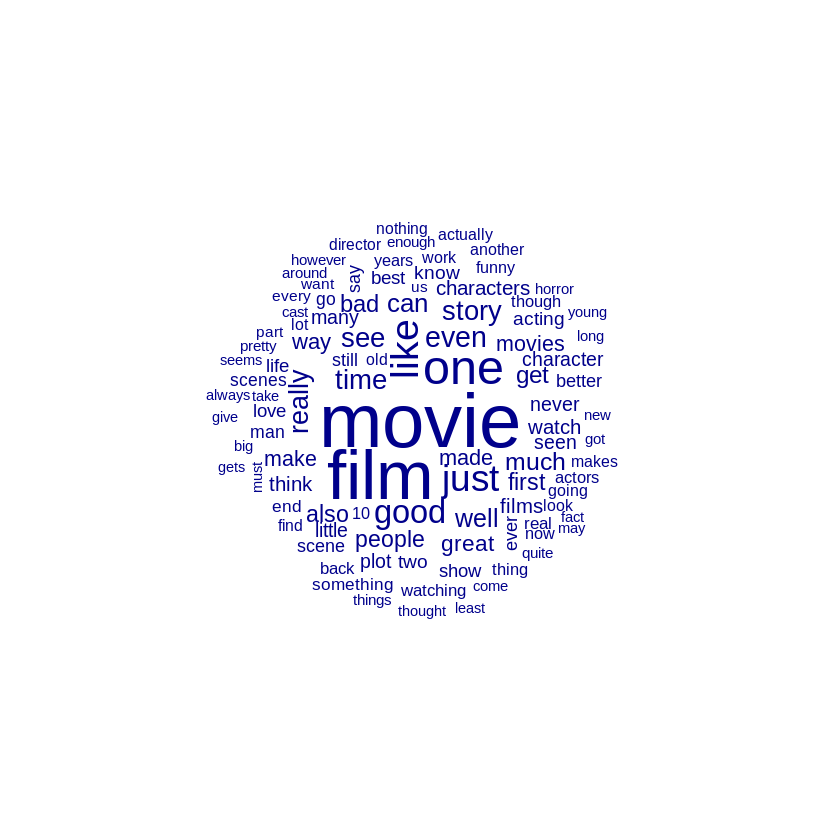

In [16]:
textplot_wordcloud(reviews_dfm, max_words = 100)

In [17]:
?textplot_wordcloud

textplot_wordcloud {quanteda.textplots},R Documentation
x,a dfm or quanteda.textstats::textstat_keyness object
min_size,size of the smallest word
max_size,size of the largest word
min_count,words with frequency below min_count will not be plotted
max_words,maximum number of words to be plotted. The least frequent terms dropped. The maximum frequency will be split evenly across categories when comparison = TRUE.
color,colour of words from least to most frequent
font,font-family of words and labels. Use default font if NULL.
adjust,adjust sizes of words by a constant. Useful for non-English words for which R fails to obtain correct sizes.
rotation,proportion of words with 90 degree rotation
random_order,"plot words in random order. If FALSE, they will be plotted in decreasing frequency."


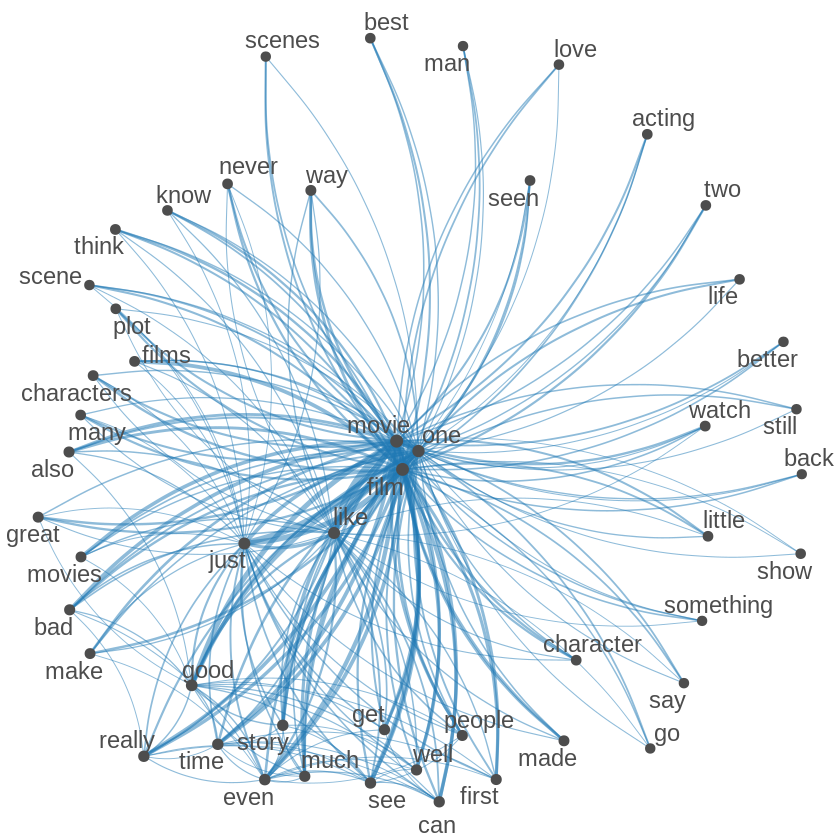

In [18]:
size <- log(colSums(dfm_select(reviews_dfm, feat, selection = "keep")))


textplot_network(fcmat_select, min_freq = 0.8, vertex_size = size / max(size) * 3)

## Statistics

We can also do statistical evaluation:



In [ ]:
# lexical diversity
tstat_lexdiv <- textstat_lexdiv(reviews_dfm, measure = "I")

head(tstat_lexdiv, 5)

glimpse(tstat_lexdiv)

In [21]:
#readability
tstat_read <- textstat_readability(review_corpus, measure = c("Flesch"))

head(tstat_read)

,document,Flesch
,<chr>,<dbl>
1,text1,56.86084
2,text2,27.58409
3,text3,43.86362
4,text4,66.96800
5,text5,50.21180
6,text6,68.90468


## Sentiment

We can also perform sentiment analysis to "score" the words based on a pre-defined dictionary.



In [22]:
lengths(data_dictionary_LSD2015)

negative     positive neg_positive neg_negative 
        2858         1709         1721         2860

In [23]:
toks_sentiment <- tokens_lookup(toks_clean, dictionary = data_dictionary_LSD2015)

dfm_sentiment <- dfm(toks_sentiment)

dfm_sentiment <- dfm_sentiment %>%
                convert(to = "data.frame") %>%
                mutate(ratio = (positive - negative)/ (negative + positive))

arrange(dfm_sentiment, desc(ratio))

doc_id,negative,positive,neg_positive,neg_negative,ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
text63,0,8,0,0,1
text194,0,3,0,0,1
text201,0,4,0,0,1
text204,0,7,0,0,1
text236,0,7,0,0,1
text246,0,4,0,0,1
text288,0,8,0,0,1
text292,0,3,0,0,1
text295,0,15,0,0,1
